In [2]:
import json
from pathlib import Path
import re
import numpy as np
from PIL import Image

import torch
import pandas as pd
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import networkx as nx
from ultralytics.utils import metrics

from utils import detection_metrics, sliced_inference, plot_bboxes

In [3]:
def get_device():
    """
    Get device
    """
    return 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [4]:
def extract_node_labels(graph, x1=0, y1=0):
    """
    Extract coordinates for nodes from GT graph
    """
    keys = ['xmin', 'ymin', 'xmax', 'ymax']

    # Regex pattern for excluding connection and backgrounds from nodes
    pattern = r"^(crossing|background|connector)"

    node_xyxy = torch.tensor([
            [int(node[1][key]) for key in keys]
            for node in graph.nodes(data=True) if not re.match(pattern, node[0])
    ])

    node_labels = torch.tensor([0 for i in range(len(node_xyxy))])

    if x1 !=0 or y1 !=0:
        node_xyxy[:, 0::2] -= x1
        node_xyxy[:, 1::2] -= y1
    
    return node_labels, node_xyxy

In [5]:
def get_origin_offset(dataset, id, root):
    offset_path = root / 'Data' / 'PID2Graph' / 'Complete' / f'{dataset}' / 'Cropped Coordinates' / f'{id}_coordinates.txt'
    coords = pd.read_csv(offset_path, sep=' ', header=None)
    x1, y1 = coords.iloc[0:2].values
    return int(x1[0]), int(y1[0])

In [6]:
def convert_midpoint_to_bbox(midpoints, bbox_width, bbox_height, x1_crop, y1_crop):
    half_w, half_h = bbox_width / 2, bbox_height / 2

    midpoints = torch.tensor(midpoints)
    midpoints[:, 0:1] += x1_crop
    midpoints[:, 1:2] += y1_crop

    xyxy = torch.cat([
        midpoints[:, 0:1] - half_w,  # x_min
        midpoints[:, 1:2] - half_h,  # y_min
        midpoints[:, 0:1] + half_w,  # x_max
        midpoints[:, 1:2] + half_h  # y_max
    ], dim=1)

    return xyxy

In [7]:
root = Path().resolve().parents[1]

# 3 Datasets: Train, Test Real, Test Synthetic
datasets = ['Dataset PID', 'PID2Graph Synthetic', 'PID2Graph OPEN100']
dataset_mapper = {'digitize': 'Dataset PID', 'synthetic': 'PID2Graph Synthetic', 'open100': 'PID2Graph OPEN100', }

pattern = re.compile(r'^(\d+)_(.*?)\.png$')

with open('Archive_xy.json', 'r') as f:
    countgd_detections = json.load(f)

# Store paths for each dataset PID image and labels 
drawing_labels_preds = {
    dataset:{
        int(match.group(1)): {
            'preds': [],
            'labels': []
        } 
        for drawing_id in countgd_detections.keys()
        if (match := pattern.match(drawing_id)) and dataset_mapper[match.group(2)] == dataset
    }
    for dataset in datasets
}

for filename in countgd_detections.keys():
    match = pattern.match(filename)
    digit, text = match.groups()
    
    dataset = dataset_mapper[text]
    graph = root / 'Data' / 'PID2Graph' / 'Complete' / f'{dataset}' / f'{digit}.graphml'
    drawing_labels_preds[dataset][int(digit)]['labels'] = graph
    drawing_labels_preds[dataset][int(digit)]['preds'] = countgd_detections[filename]

In [8]:
detection_results = {
    key: {'map': []} for key in drawing_labels_preds.keys()
}

In [16]:
taskdevice = get_device()

for dataset in drawing_labels_preds.keys():

    map_metric = MeanAveragePrecision(iou_type='bbox', class_metrics=True, iou_thresholds=[0.5], max_detection_thresholds=[100, 150, 200])
    
    for dwg in drawing_labels_preds[dataset].keys():

        x1_crop, y1_crop = get_origin_offset(dataset, dwg, root)

        label = drawing_labels_preds[dataset][dwg]['labels']
        graph = nx.read_graphml(label) 
        labels, labels_xyxy = extract_node_labels(graph)
        
        pred_bboxes = convert_midpoint_to_bbox(drawing_labels_preds[dataset][dwg]['preds'], bbox_height=150, bbox_width=150, x1_crop=x1_crop, y1_crop=y1_crop)

        scores = torch.tensor([1.0 for i in range(len(pred_bboxes))])
        predicted_class = torch.tensor([0 for i in range(len(pred_bboxes))])

        preds = [{"boxes": pred_bboxes, "scores": scores, "labels": predicted_class}]
        targets = [{"boxes": labels_xyxy, "labels": labels}]
        map_metric.update(preds, targets)
        

    detection_results[dataset] = map_metric.compute()['map'].item()
    map_metric.reset()
    

In [19]:
detection_results

{'Dataset PID': 0.00033697063918225467,
 'PID2Graph Synthetic': 0.2135109007358551,
 'PID2Graph OPEN100': 0.0001523229293525219}

In [20]:
pred_bboxes = convert_midpoint_to_bbox(drawing_labels_preds['Dataset PID'][0]['preds'], bbox_height=150, bbox_width=150, x1_crop=353, y1_crop=255)

In [21]:
label = drawing_labels_preds['PID2Graph Synthetic'][1]['labels']
graph = nx.read_graphml(label) 
labels, labels_xyxy = extract_node_labels(graph, x1_crop, y1_crop)

In [24]:
root = Path().resolve().parents[1]
im_path = root / 'Data' / 'PID2Graph' / 'Complete' / 'Dataset PID' / '0.png'
im = Image.open(im_path)

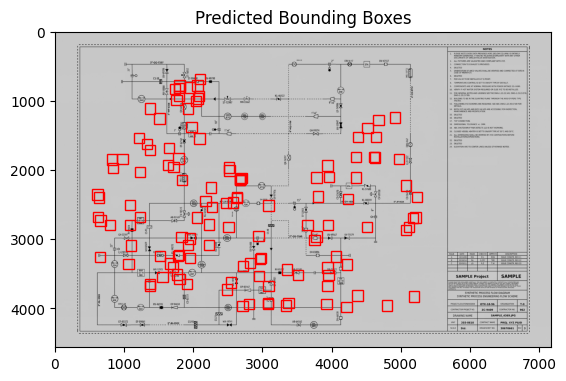

In [25]:
im_np = np.array(im)
plot_bboxes(im_np, pred_bboxes.cpu(), box_color='r', title='Predicted Bounding Boxes')